In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d alessiocorrado99/animals10

 99% 581M/586M [00:11<00:00, 99.2MB/s]
100% 586M/586M [00:11<00:00, 53.1MB/s]


In [ ]:
!unzip "/content/animals10.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: /content/dataset/raw-img/ragno/OIP

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras.src.layers import MultiHeadAttention
from keras.src.layers.serialization import activation
from tensorflow.keras.layers import Layer, Dropout,MaxPooling2D,GlobalAveragePooling2D,Activation,Add,LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer,Dense,Conv2D,MaxPool2D,Flatten,BatchNormalization,Input,RandomFlip, RandomRotation, Resizing, Rescaling,RandomContrast
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TrueNegatives, TruePositives, Precision, Recall, AUC, CategoricalAccuracy,TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy,SparseCategoricalCrossentropy
import sklearn
import tensorflow_probability as tfp
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.regularizers import L2, L1
from tensorflow.train import BytesList,FloatList,Int64List
from tensorflow.train import Example, Feature, Features
import seaborn as sns
import  cv2
from tensorflow.keras.callbacks import Callback, CSVLogger,EarlyStopping,LearningRateScheduler,ModelCheckpoint, ReduceLROnPlateau

In [ ]:
dataset_dir = "/content/dataset/raw-img"

CONFIG = {
    "IM_SIZE" : 180,
    "BATCH_SIZE" : 32,
}

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset = 'training',
    image_size = (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"]),
    batch_size = CONFIG["BATCH_SIZE"],
    seed = 123,
    label_mode = 'categorical',
)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset = 'validation',
    image_size = (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"]),
    batch_size = CONFIG["BATCH_SIZE"],
    seed = 123,
    label_mode = 'categorical',
)

Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


In [ ]:
print(train_ds)
print(val_ds)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


In [ ]:
class_names = train_ds.class_names
print(class_names)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [ ]:
pretrained_model = tf.keras.applications.ResNet50(
    include_top= False,
    input_shape= (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"],3),
    classes= len(class_names),
    pooling = "avg", # or max
    weights = "imagenet"
)

for layer in pretrained_model.layers:
  layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet_model = tf.keras.models.Sequential([
    pretrained_model,
    Flatten(),
    Dense(512,activation='relu'),
    Dense(len(class_names),activation = 'softmax')
])

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 24641930 (94.00 MB)
Trainable params: 1054218 (4.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
resnet_model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = resnet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10,
)

Epoch 1/10
655/655 [==============================] - 74s 93ms/step - loss: 0.3695 - accuracy: 0.8871 - val_loss: 0.2995 - val_accuracy: 0.8965
Epoch 2/10
655/655 [==============================] - 68s 103ms/step - loss: 0.2094 - accuracy: 0.9301 - val_loss: 0.2900 - val_accuracy: 0.9068
Epoch 3/10
655/655 [==============================] - 58s 88ms/step - loss: 0.1542 - accuracy: 0.9482 - val_loss: 0.2787 - val_accuracy: 0.9152
Epoch 4/10
655/655 [==============================] - 59s 89ms/step - loss: 0.1148 - accuracy: 0.9610 - val_loss: 0.2765 - val_accuracy: 0.9163
Epoch 5/10
655/655 [==============================] - 68s 103ms/step - loss: 0.0898 - accuracy: 0.9709 - val_loss: 0.2981 - val_accuracy: 0.9228
Epoch 6/10
655/655 [==============================] - 59s 89ms/step - loss: 0.0639 - accuracy: 0.9781 - val_loss: 0.2893 - val_accuracy: 0.9261
Epoch 7/10
655/655 [==============================] - 59s 89ms/step - loss: 0.0654 - accuracy: 0.9781 - val_loss: 0.3044 - val_accurac

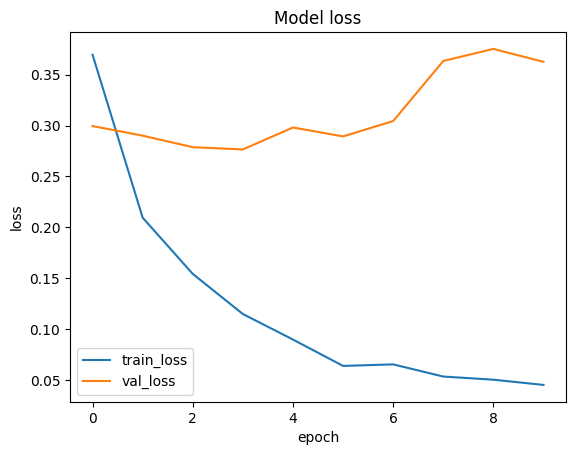

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["train_loss","val_loss"])
plt.show()

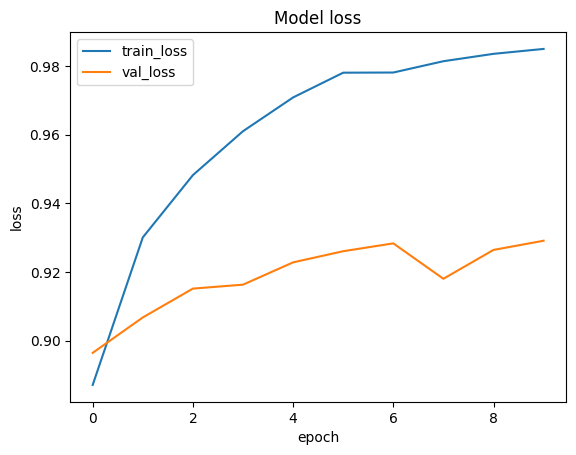

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["train_loss","val_loss"])
plt.show()

1/1 [==============================] - 0s 164ms/step


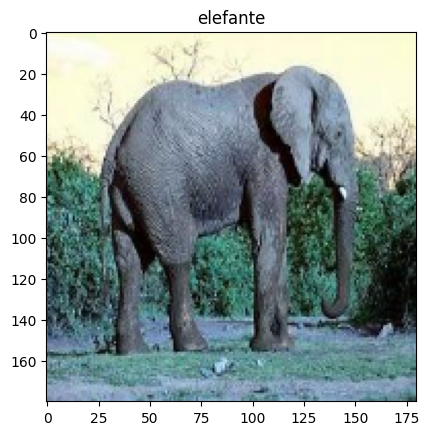

In [ ]:
test_img = cv2.imread("/content/dataset/raw-img/elefante/OIP--3aF2OpzGKcdI6FHil50qQHaFj.jpeg")
test_img = cv2.resize(test_img,(CONFIG["IM_SIZE"],CONFIG["IM_SIZE"]))

img_prediction = tf.keras.preprocessing.image.img_to_array(test_img)
img_prediction = tf.expand_dims(test_img, axis = 0)
prediction = resnet_model.predict(img_prediction)
plt.title(class_names[np.argmax(prediction)])

plt.imshow(test_img)